## Problema QUBO con l'ottimizzatore Grover

In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
#provider = IBMQ.load_account()

## Introduzione

In questa esercitazione presentiamo brevemente come costruire problemi di ottimizzazione utilizzando il modulo di ottimizzazione di Qiskit.
Qiskit introduce la classe `QuadraticProgram` per creare un modello di un problema di ottimizzazione.
Più precisamente, si occupa di programmi quadratici vincolati dati come segue:


$$
\begin{align}
\text{minimize}\quad& x^\top Q_0 x + c^\top x\\
\text{subject to}\quad& A x \leq b\\
& x^\top Q_i x + a_i^\top x \leq r_i, \quad 1,\dots,i,\dots,q\\
& l_i \leq x_i \leq u_i, \quad 1,\dots,i,\dots,n,
\end{align}
$$

dove le $Q_i$ sono matrici $n \times n$, $A$ è una matrice $m \times n$, $x$, e $c$ sono vettori $n$-dimensionali, $b$ è un vettore $m$-dimensionale, e dove $x$ può essere una variabile binaria, intera, o continua.
In aggiunta ai vincoli "$\leq$" il 'QuadraticProgram' supporta anche "$\geq$" e "$=$".

I problemi di ottimizzazione nel modulo di ottimizzazione di Qiskit sono rappresentati con la classe `QuadraticProgram`, che è una rappresentazione generica e potente per i problemi di ottimizzazione. In generale, gli algoritmi di ottimizzazione sono definiti per una certa formulazione di un programma quadratico e dobbiamo convertire il nostro problema nel tipo giusto.

Ad esempio, Qiskit fornisce diversi algoritmi di ottimizzazione in grado di gestire problemi di "ottimizzazione binaria non vincolata quadratica" (QUBO). Questi vengono mappati su hamiltoniani di Ising, per i quali Qiskit utilizza il modulo `qiskit.aqua.operators`, e poi il loro stato fondamentale viene approssimato. Per questa ottimizzazione si possono utilizzare algoritmi comunemente noti come VQE o QAOA come routine di base. Per maggiori dettagli si veda il seguente tutorial su [Minimum Eigen Optimizer](./3_minimum_eigen_optimizer.ipynb). Si noti che esistono anche altri algoritmi che funzionano in modo diverso, come il `GroverOptimizer`.

Per mappare un problema nel formato di input corretto, il modulo di ottimizzazione di Qiskit offre una serie di convertitori. In questo tutorial forniremo una panoramica su questa funzionalità. Attualmente, Qiskit contiene i seguenti convertitori.
- `InequalityToEquality`: converte i vincoli di disuguaglianza in vincoli di uguaglianza con variabili aggiuntive di slack.
- `IntegerToBinary`: converte variabili intere in variabili binarie e coefficienti corrispondenti. 
- LinearEqualityToPenalty`: converte i vincoli di uguaglianza in termini aggiuntivi della funzione oggetto.
- `QuadraticProgramToQubo`: un wrapper per `InequalityToEquality`, `IntegerToBinary` e `LinearEqualityToPenalty` per comodità.

## Variational Quantum Eigensolver (VQE)
 Trovare la soluzione di un QUBO equivale a trovare lo stato fondamentale della corrispondente hamiltoniana di Ising, un problema importante non solo nell'ottimizzazione, ma anche nella chimica e nella fisica quantistica. Per questa traduzione, le variabili binarie che assumono valori in ${0, 1}$ sono sostituite da variabili di spin che assumono valori in ${-1, +1}$, il che consente di sostituire le variabili di spin risultanti con matrici di Pauli Z e, quindi, con un'Hamiltoniana di Ising. 

Qiskit fornisce una conversione automatica da un opportuno `Programma Quadratico' a un'Hamiltoniana di Ising, che permette poi di sfruttare tutti i "MinimumEigenSolver" come
- `VQE`,
- `QAOA`, o
- `NumpyMinimumEigensolver` (metodo esatto classico).


## Annealer
La ricottura quantistica (Quantum Annealing) è un processo di ottimizzazione per trovare il minimo globale di una data funzione obiettivo su un dato insieme di soluzioni candidate (stati candidati), mediante un processo che utilizza le fluttuazioni quantistiche. L'annealing quantistico è utilizzato principalmente per problemi in cui lo spazio di ricerca è discreto (problemi di ottimizzazione combinatoria) con molti minimi locali; come ad esempio il problema del commesso viaggiatore. 

La ricottura quantistica parte da una sovrapposizione di tutti gli stati possibili (stati candidati) con pesi uguali. Poi il sistema si evolve seguendo l'equazione di Schrödinger dipendente dal tempo, una naturale evoluzione quantomeccanica dei sistemi fisici. Le ampiezze di tutti gli stati candidati continuano a cambiare, realizzando un parallelismo quantistico, in base all'intensità del campo trasversale dipendente dal tempo, che causa il tunneling quantistico tra gli stati. Il campo trasverso viene infine spento e si prevede che il sistema abbia raggiunto lo stato fondamentale del modello classico di Ising che corrisponde alla soluzione del problema di ottimizzazione originale.
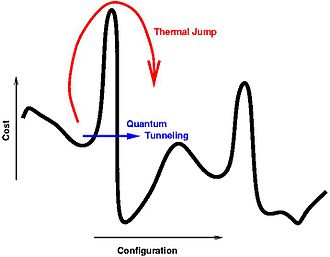

# Grover Optimizer

La ricerca adattativa di Grover (GAS) è stata studiata come possibile soluzione per i problemi di ottimizzazione combinatoria. L'algoritmo applica iterativamente la ricerca di Grover per trovare il valore ottimale di una funzione obiettivo, utilizzando come soglia il valore più noto dell'esecuzione precedente. L'oracolo adattivo utilizzato in GAS riconosce tutti i valori superiori o inferiori alla soglia corrente (rispettivamente per max e min), diminuendo la dimensione dello spazio di ricerca a ogni iterazione in cui la soglia viene aggiornata, fino a quando non viene trovato un ottimo.

## Grover Adaptive Search
La ricerca di Grover, l'elemento centrale del GAS, ha bisogno di tre ingredienti:

1. Un operatore di preparazione degli stati $A$ per costruire una sovrapposizione di tutti gli stati nello spazio di ricerca.

2. Un operatore oracolo $O$, che riconosce gli stati di interesse e moltiplica le loro ampiezze per -1.

3. L'operatore di diffusione di Grover $D$, che moltiplica per -1 l'ampiezza dello stato $|0\rangle_n$.

Anche se le implementazioni di GAS variano a seconda del caso d'uso specifico, il quadro generale segue vagamente le fasi descritte di seguito.

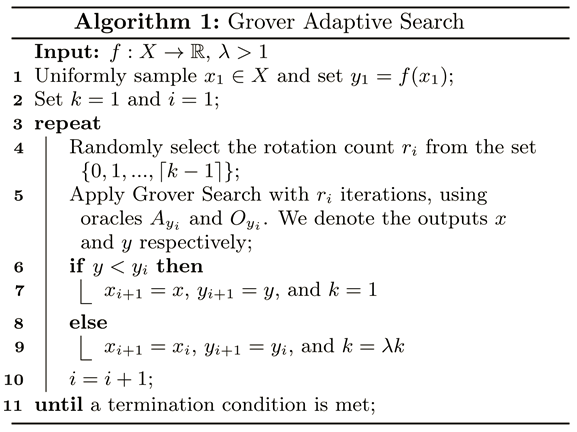

Il ```GroverOptimizer``` usa ```QuadraticProgramToNegativeValueOracle``` per costruire $A_y$ in modo tale da preparare un registro a $n$-qubit per rappresentare la sovrapposizione uguale di tutti gli $|x\rangle_n$ e un registro a $m$-qubit per rappresentare (approssimativamente) il corrispondente $|Q(x)-y\rangle_m$. Quindi, tutti gli stati con $(Q(x) - y)$ negativo devono essere contrassegnati da $O_y$. Si noti che nell'implementazione discussa, l'operatore oracolo è in realtà indipendente da $y$, ma questo non è un requisito. Per chiarezza, ci riferiremo all'oracolo come $O$ quando è indipendente da $y$.

In termini formali, `QuadraticProgramToNegativeValueOracle` costruisce un $A_y$ e $O$ tale che:

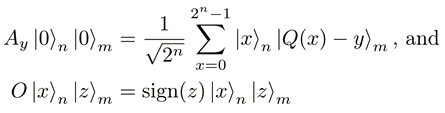

dove $|x\rangle$ è la codifica binaria dell'intero $x$. 

A ogni iterazione in cui la soglia $y$ viene aggiornata, adattiamo $A_y$ in modo che i valori della funzione siano spostati verso l'alto o verso il basso (rispettivamente per il minimo e il massimo) di $y$. Ad esempio, nel contesto della ricerca del minimo, al diminuire del valore di $y$ diminuisce anche lo spazio di ricerca (valori negativi), finché non rimane solo il valore minimo. Un esempio concreto sarà esaminato nella prossima sezione.

## Il problema

Quello che segue è un esempio giocattolo di problema di minimizzazione.

\begin{eqnarray}
\min_{x \in \{0, 1\}^3} -2x_1x_3 - x_2x_3 - 1x_1 + 2x_2 - 3x_3.
\end{eqnarray}

Per i nostri passi iniziali, creiamo un modello che definisce il problema di cui sopra e che può essere utilizzato per rappresentare un QUBO in Qiskit Optimization.

In [1]:
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import GroverOptimizer,MinimumEigenOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit import BasicAer

backend = BasicAer.get_backend('statevector_simulator')

## Caricamento di un `programma quadratico'

In [2]:

qp = QuadraticProgram("sample")
qp.binary_var("x0")
qp.binary_var("x1")
qp.binary_var("x2")
qp.minimize(linear={"x0": -1, "x1": 2, "x2":-3},quadratic ={("x0","x2"): -2, ("x1","x2"): -1})
print(qp.prettyprint())

Problem name: sample

Minimize
  -2*x0*x2 - x1*x2 - x0 + 2*x1 - 3*x2

Subject to
  No constraints

  Binary variables (3)
    x0 x1 x2



In [3]:
backend = BasicAer.get_backend('statevector_simulator')

Quindi, creiamo un `GroverOptimizer` che usa 6 qubit per codificare il valore e che terminerà dopo 10 iterazioni di GAS senza progressi (cioè il valore di $y$ non cambia). La funzione `solve()` prende il `QuadraticProgram` creato in precedenza e restituisce un oggetto results che contiene informazioni sull'esecuzione.

In [4]:
grover_optimizer = GroverOptimizer(6, num_iterations=10, quantum_instance=backend)
results = grover_optimizer.solve(qp)
print("x={}".format(results.x))
print("fval={}".format(results.fval))

x=[1. 0. 1.]
fval=-6.0


## Verificare che GroverOptimizer trovi il valore corretto

Possiamo verificare che l'algoritmo funzioni correttamente utilizzando il `MinimumEigenOptimizer` di Qiskit.

In [5]:
exact_solver = MinimumEigenOptimizer(NumPyMinimumEigensolver())
exact_result = exact_solver.solve(qp)
print("x={}".format(exact_result.x))
print("fval={}".format(exact_result.fval))

x=[1. 0. 1.]
fval=-6.0


## Affrontiamo un problema di ottimizzazione:

Siamo organizzatori di eventi e dobbiamo decidere come distribuire 5 eventi in due giorni (sabato e domenica)
per fare in modo che si massimizzi il numero delle affluenze.
L'evento prende un intero giorno quindi non si possono seguire due eventi in un giorno.
Alcune persone (4) hanno espresso le loro preferenze per gli eventi:
1) la persona P1 vorrebbe partecipare agli eventi 1 e 4
2) la persona P2 agli eventi 2 e 3
3) la persona P3 agli eventi 4 e 5
4) la persona P4 agli eventi 3 e 4

Nel seguito cerchiamo di modellare correttamente il problema

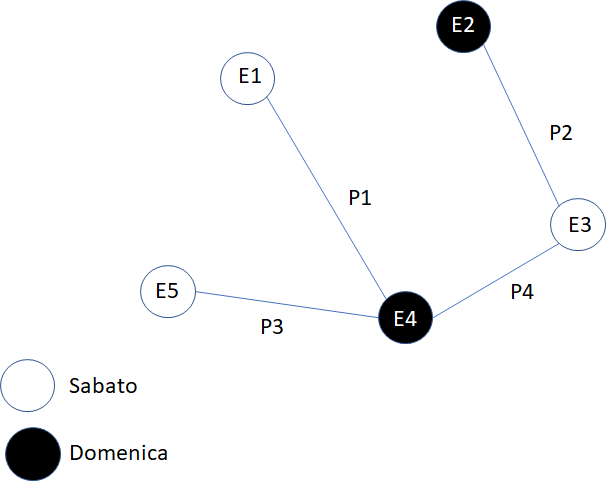



$ $

$x_1 +x_4  -2 x_1x_4 +$

$x_2 +x_3  -2 x_2x_3 +$

$x_4 +x_5  -2 x_4x_5 +$

$x_3 +x_4  -2 x_3x_4$